In [ ]:
import numpy as np
from numba import cuda
import math
import time
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
@cuda.jit
def bilateral_kern(input_img, output_img, d, sr, sd):
  r = d//2
  i, j = cuda.grid(2)
  if i < input_img.shape[0] and j < input_img.shape[1]:
      h = 0
      k = 0
      for ik in range(i - r, i + r + 1):
        for jk in range(j - r, j + r + 1):
          if ik >= 0 and ik < input_img.shape[0] and jk >= 0 and jk < input_img.shape[1]:
            x = ik - i
            y = jk - j
            w = math.exp(-((x**2 - y**2)/(sd**2))) * math.exp(((int(input_img[ik][jk]) - int(input_img[i][j]))**2)/(sr**2))
            h += input_img[ik][jk]*w
            k += w
      output_img[i][j] = h/k


In [ ]:
def bilateral_gpu(h_input_img, d, sr, sd):
  block_size = (32, 32)
  grid_size=(math.ceil(h_input_img.shape[0]/block_size[0]), math.ceil(h_input_img.shape[1]/block_size[1]))

  start = cuda.event()
  end = cuda.event()

  start.record()

  d_input_img = cuda.to_device(h_input_img)
  d_output_img = cuda.to_device(np.zeros(h_input_img.shape))
  bilateral_kern[grid_size, block_size](d_input_img, d_output_img, d, sr, sd)

  end.record()
  end.synchronize()

  elapsed_time = cuda.event_elapsed_time(start, end)
  return d_output_img.copy_to_host(), elapsed_time / 1000

In [ ]:
def bilateral_cpu(input_img, d, sr, sd):
  output_img = np.zeros(input_img.shape)
  r = d//2
  for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
      h = 0
      k = 0
      for ik in range(i - r, i + r + 1):
        for jk in range(j - r, j + r + 1):
          if ik >= 0 and ik < input_img.shape[0] and jk >= 0 and jk < input_img.shape[1]:
            x = ik - i
            y = jk - j
            w = math.exp(-((x**2 - y**2)/(sd**2))) * math.exp(((int(input_img[ik][jk]) - int(input_img[i][j]))**2)/(sr**2))
            h += input_img[ik][jk]*w
            k += w
      output_img[i][j] = h/k
  return output_img

In [ ]:
img = cv2.imread('/content/peppers.bmp', cv2.IMREAD_GRAYSCALE)
d, sr, sd = 5, 500, 500

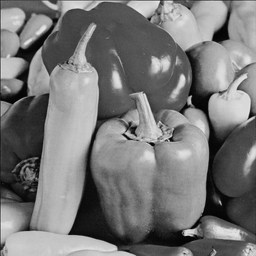

In [ ]:
cv2_imshow(img)

------------------CPU------------------
CPU time is: 8.114638805389404


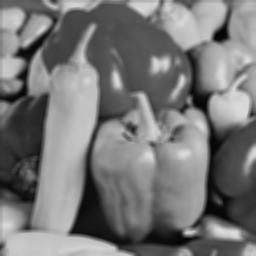

In [ ]:
print("------------------CPU------------------")
start_cpu = time.time()
result_cpu = bilateral_cpu(img, d, sr, sd)
total_time_cpu = time.time() - start_cpu
print(f"CPU time is: {total_time_cpu}")
cv2_imshow(result_cpu)

------------------GPU------------------


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


GPU time is: 1.83682861328125


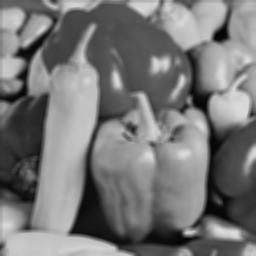

In [ ]:
print("------------------GPU------------------")
result_gpu, time_gpu = bilateral_gpu(img, d, sr, sd)
print(f"GPU time is: {time_gpu}")
cv2_imshow(result_gpu)

In [ ]:
print("------------------Acceleration------------------")
print(total_time_cpu/time_gpu)

------------------Acceleration------------------
4.417744119792255


------------------CPU------------------
CPU time is: 9.849362134933472


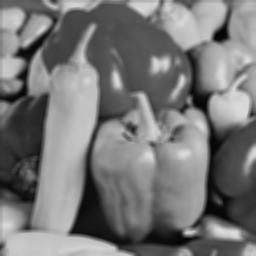

------------------GPU------------------
GPU time is: 0.005126272201538086


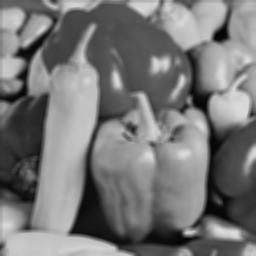

------------------CPU------------------
CPU time is: 1.9386425018310547


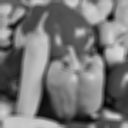

------------------GPU------------------
GPU time is: 0.004450975894927978


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


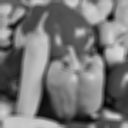

------------------CPU------------------
CPU time is: 0.44118642807006836


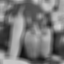

------------------GPU------------------
GPU time is: 0.0034309120178222657


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


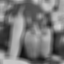

In [ ]:
imgs = ['peppers', 'peppers128', 'peppers64']
for imG in imgs:
  img = cv2.imread('/content/'+imG+'.bmp', cv2.IMREAD_GRAYSCALE)
  print("------------------CPU------------------")
  start_cpu = time.time()
  result_cpu = bilateral_cpu(img, d, sr, sd)
  total_time_cpu = time.time() - start_cpu
  print(f"CPU time is: {total_time_cpu}")
  cv2_imshow(result_cpu)
  print("------------------GPU------------------")
  result_gpu, time_gpu = bilateral_gpu(img, d, sr, sd)
  print(f"GPU time is: {time_gpu}")
  cv2_imshow(result_gpu)

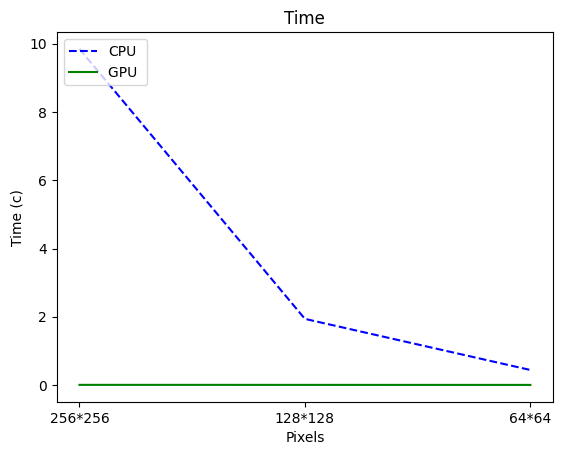

In [ ]:
import matplotlib.pyplot as plt
time_cpu = [9.849362134933472, 1.9386425018310547, 0.44118642807006836]
time_gpu = [0.005126272201538086, 0.004450975894927978, 0.0034309120178222657]
size = ['256*256','128*128','64*64']
plt.title('Time')
plt.xlabel('Pixels')
plt.ylabel('Time (c)')
plt.plot(size,time_cpu,'b--',size,time_gpu,'g')
plt.legend(['CPU','GPU '], loc=2)
plt.show()

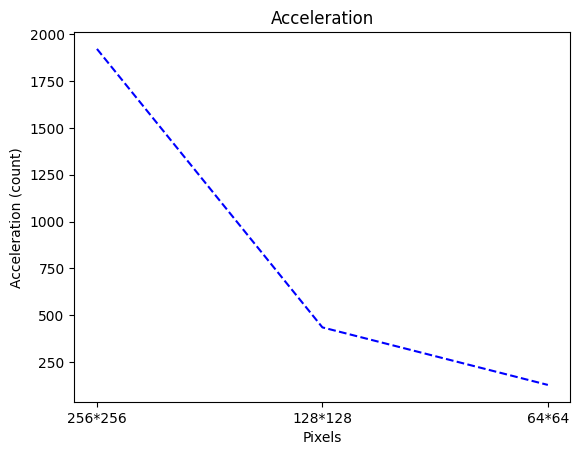

In [ ]:
plt.cla()
plt.title('Acceleration')
plt.xlabel('Pixels')
plt.ylabel('Acceleration (count)')
accel = []
for i in range (len(time_cpu)):
  accel.append(time_cpu[i]/time_gpu[i])

plt.plot(size,accel,'b--')
plt.show()